In [2]:
import pandas as pd
import click
import os
import sys
import json
from requests_helper import branch_to_hash, post_analyze, get_results, get_status
from git import Repo, GitCommandError
import subprocess
from github import Github

user_token = os.getenv('MUSEDEV_TOKEN')
gh_token = os.getenv('GH_GITHUB_API_TOKEN')
g = Github(gh_token)

In [5]:
repos = g.search_repositories('language:Go')
top10 = list(repos[:10])

In [6]:
top10[0]

Repository(full_name="golang/go")

In [3]:
def analyze(reponame):
    branch = g.get_repo(reponame).default_branch
    [owner,repo] = reponame.split("/")
    commit = branch_to_hash(owner, repo, branch)
    return post_analyze(user_token, owner, repo, commit).strip("\"")

def status(job_id):
    return get_status(user_token, job_id)

def job_complete(job_id):
    status = get_status(user_token, job_id)
    return "Complete" in status

def results(job_id):
    return get_results(user_token, job_id)

In [4]:
repos = pd.read_csv('../pldi_repos.csv')

In [5]:
repos

,repo
0,ReactiveX/RxJava
1,google/guava
2,square/retrofit
3,apache/dubbo
4,netty/netty
5,greenrobot/EventBus
6,skylot/jadx
7,alibaba/fastjson
8,alibaba/arthas
9,halo-dev/halo


In [6]:
def fork(org,repo):
    user = g.get_user()
    org = g.get_organization(org)
    repo = org.get_repo(repo)
    my_fork = user.create_fork(repo)
    return my_fork

def clone(repo):
    try:
        local_repo = Repo.clone_from("git@github.com:" + str(user.login) + "/" + str(repo.name) + ".git",
                                     os.getcwd() + "/" + str(repo.name), branch="master")
        Repo.create_remote(local_repo, "upstream", "git@github.com:" + url[0] + "/" + url[1] + ".git")
except GitCommandError:
    print "Directory already exists and is not empty. Not cloning."
    pass

def add_muse_config():
    
    
def get_loc(repo_name):
    print("get_loc({})".format(repo_name))
    repo = g.get_repo(repo_name)
    subprocess.run(['git clone '+repo.clone_url+' checkout'], shell=True)
    loc = int(subprocess.check_output(['cloc checkout --include-lang=Java --quiet --yaml | grep code | head -n 1 | cut -d : -f 2'],shell=True))
    subprocess.run(['rm','-rf','checkout'])
    return loc

In [7]:
repos['loc'] = repos['repo'].apply(get_loc)

get_loc(ReactiveX/RxJava)
get_loc(google/guava)
get_loc(square/retrofit)
get_loc(apache/dubbo)
get_loc(netty/netty)
get_loc(greenrobot/EventBus)
get_loc(skylot/jadx)
get_loc(alibaba/fastjson)
get_loc(alibaba/arthas)
get_loc(halo-dev/halo)
get_loc(jenkinsci/jenkins)
get_loc(xuxueli/xxl-job)
get_loc(dbeaver/dbeaver)
get_loc(mybatis/mybatis-3)
get_loc(seata/seata)
get_loc(redisson/redisson)
get_loc(looly/hutool)


In [8]:
repos

,repo,loc
0,ReactiveX/RxJava,310530
1,google/guava,398320
2,square/retrofit,26496
3,apache/dubbo,168990
4,netty/netty,287499
5,greenrobot/EventBus,5364
6,skylot/jadx,69902
7,alibaba/fastjson,176268
8,alibaba/arthas,39472
9,halo-dev/halo,24196


In [9]:
repos['jobid'] = repos['repo'].apply(analyze)

In [10]:
repos

,repo,loc,jobid
0,ReactiveX/RxJava,310530,01EAYH6X015R4EDRYNP5EJD0QX
1,google/guava,398320,01EAYH6XJ8R8NZJ96PWBP187JV
2,square/retrofit,26496,01EAYH6Y0QD9YC0NA3YPJ163Y0
3,apache/dubbo,168990,01EAYH6YGPV56TBFAMKFMJEFSR
4,netty/netty,287499,01EAYH6YZ4KTQSGARKRGPA1Y74
5,greenrobot/EventBus,5364,01EAYH6ZDW2HSBF4BC7W3T5M3Q
6,skylot/jadx,69902,01EAYH6ZWN3H2ZY0QCQM1F93ET
7,alibaba/fastjson,176268,01EAYH70A6VKJG966JY99QYB15
8,alibaba/arthas,39472,01EAYH70PGXKDWDYK7HGHNMK2G
9,halo-dev/halo,24196,01EAYH714YNNH8XAP3HJ9ZJGQK


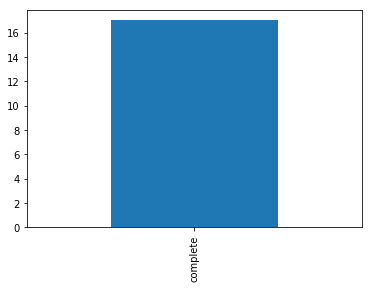

In [107]:
repos['status'] = repos['jobid'].apply(status)
repos['job_complete'] = repos['jobid'].apply(job_complete)
repos['job_status'] = repos['job_complete'].apply(lambda x: "complete" if x else "running")
repos['job_status'].value_counts().plot(kind='bar')

In [108]:
repos

,repo,loc,jobid,status,job_complete,job_status
0,ReactiveX/RxJava,310530,01EAYH6X015R4EDRYNP5EJD0QX,"""JobCompleteSuccess""",True,complete
1,google/guava,398320,01EAYH6XJ8R8NZJ96PWBP187JV,"""JobCompleteSuccess""",True,complete
2,square/retrofit,26496,01EAYH6Y0QD9YC0NA3YPJ163Y0,"""JobCompleteSuccess""",True,complete
3,apache/dubbo,168990,01EAYH6YGPV56TBFAMKFMJEFSR,"""JobCompleteSuccess""",True,complete
4,netty/netty,287499,01EAYH6YZ4KTQSGARKRGPA1Y74,"""JobCompleteSuccess""",True,complete
5,greenrobot/EventBus,5364,01EAYH6ZDW2HSBF4BC7W3T5M3Q,"""JobCompleteSuccess""",True,complete
6,skylot/jadx,69902,01EAYH6ZWN3H2ZY0QCQM1F93ET,"""JobCompleteSuccess""",True,complete
7,alibaba/fastjson,176268,01EAYH70A6VKJG966JY99QYB15,"""JobCompleteSuccess""",True,complete
8,alibaba/arthas,39472,01EAYH70PGXKDWDYK7HGHNMK2G,"""JobCompleteSuccess""",True,complete
9,halo-dev/halo,24196,01EAYH714YNNH8XAP3HJ9ZJGQK,"""JobCompleteSuccess""",True,complete


In [20]:
get_results_for_num(2)

[[[{'tag': 'Infer'}, '.'],
  {'ToolResultSuccess': {'toolNotes': [{'tnType': 'NULL_DEREFERENCE',
      'tnDesc': 'object `rawBody` last assigned on line 216 could be null and is dereferenced at line 222.',
      'tnFile': 'retrofit/src/main/java/retrofit2/OkHttpCall.java',
      'tnLine': 222,
      'tnColumn': -1,
      'tnPatch': None,
      'tnCodeLine': None,
      'tnProcedure': 'retrofit2.OkHttpCall.parseResponse(okhttp3.Response):retrofit2.Response',
      'tnIdentifier': None,
      'tnPhase': 'PhaseUnknown',
      'tnTool': {'tag': 'Infer'},
      'tnResidue': None},
     {'tnType': 'RESOURCE_LEAK',
      'tnDesc': 'resource of type `okhttp3.mockwebserver.MockWebServer` acquired to `server` by call to `new()` at line 107 is not released after line 133.\n**Note**: potential exception at line 114',
      'tnFile': 'samples/src/main/java/com/example/retrofit/ChunkingConverter.java',
      'tnLine': 133,
      'tnColumn': -1,
      'tnPatch': None,
      'tnCodeLine': None,
      

In [141]:
import json

In [142]:
with open('testjson.json') as f:
  data = json.load(f)

In [221]:
repos.head()

,repo,loc,jobid,status,job_complete,job_status
0,ReactiveX/RxJava,310530,01EAXQSYJSBCJSY3TTPCCAA2RD,"""JobCompleteSuccess""",True,complete
1,google/guava,398320,01EAXQSZ4YVS12B178FA2537J1,"""JobCompleteSuccess""",True,complete
2,square/retrofit,26496,01EAXQSZMXP5R57A485HXM86K3,"""JobCompleteSuccess""",True,complete
3,apache/dubbo,168990,01EAXQT032J20XK7B6HTJNQRR1,"""JobCompleteSuccess""",True,complete
4,netty/netty,287499,01EAXQT0HTHNZKMP8XJCT3GM77,"""JobCompleteSuccess""",True,complete


In [46]:
indexed_repos = repos.set_index('repo')

In [50]:
indexed_repos

,loc,jobid,status,job_complete,job_status
repo,,,,,
ReactiveX/RxJava,310530,01EAYH6X015R4EDRYNP5EJD0QX,"""JobCompleteSuccess""",True,complete
google/guava,398320,01EAYH6XJ8R8NZJ96PWBP187JV,"""JobCodeAcquired""",False,running
square/retrofit,26496,01EAYH6Y0QD9YC0NA3YPJ163Y0,"""JobCompleteSuccess""",True,complete
apache/dubbo,168990,01EAYH6YGPV56TBFAMKFMJEFSR,"""JobCompleteSuccess""",True,complete
netty/netty,287499,01EAYH6YZ4KTQSGARKRGPA1Y74,"""JobCodeAcquired""",False,running
greenrobot/EventBus,5364,01EAYH6ZDW2HSBF4BC7W3T5M3Q,"""JobCompleteSuccess""",True,complete
skylot/jadx,69902,01EAYH6ZWN3H2ZY0QCQM1F93ET,"""JobCodeAcquired""",False,running
alibaba/fastjson,176268,01EAYH70A6VKJG966JY99QYB15,"""JobCompleteSuccess""",True,complete
alibaba/arthas,39472,01EAYH70PGXKDWDYK7HGHNMK2G,"""JobCompleteSuccess""",True,complete


In [52]:
indexed_repos.loc['square/retrofit']['jobid']

'01EAYH6Y0QD9YC0NA3YPJ163Y0'

In [65]:
def simplify_results(results_json):
    results = list()
    for res in results_json[0][1]['ToolResultSuccess']['toolNotes']:
        results.append({'type':res['tnType'], 'file':res['tnFile']})
    return results
def get_results_for_num(num):
    return results(repos['jobid'][num])
def get_results_summary(repo_name):
    print(repo_name)
    try:
        jobid = indexed_repos.loc[repo_name]['jobid']
        res = simplify_results(results(jobid))
        results_df = pd.DataFrame(res)
        job_results = results_df.groupby('type').count().T.set_index(pd.Index([repo_name]))
        return job_results
    except:
        return None

In [60]:
get_results_for_num(2)[7]

[[{'tag': 'Infer'}, 'retrofit-adapters/scala'],
 {'ToolResultFailure': {'ToolSurfaceableFailure': ["Could not understand project's build system.",
    "Muse was unable to use your project's build system to produce a compilation database.\nPlease see the below log and muse's repository configuration documentation at https://docs.muse.dev\n"]}}]

In [109]:
get_results_summary('square/retrofit')

square/retrofit


type,NULL_DEREFERENCE,RESOURCE_LEAK,THREAD_SAFETY_VIOLATION
square/retrofit,9,10,2


In [82]:
output_df = indexed_repos.copy()
for repo in repos['repo']:
    summary = get_results_summary(repo)
    if not summary is None:
        shared_columns = output_df.columns.intersection(summary.columns)
        new_columns = summary.columns.difference(shared_columns)
        if not shared_columns.empty:
            output_df = output_df.merge(summary[shared_columns])
            print(output_df)

for repo in repos['repo']:
    summary = get_results_summary(repo)
    if not summary is None:
        shared_columns = output_df.columns.intersection(summary.columns)
        new_columns = summary.columns.difference(shared_columns)            
        if not new_columns.empty:
            output_df = output_df.join(summary[new_columns])
            print(output_df)
output_df

ReactiveX/RxJava
google/guava
square/retrofit
apache/dubbo
netty/netty
greenrobot/EventBus
skylot/jadx
alibaba/fastjson
alibaba/arthas
halo-dev/halo
jenkinsci/jenkins
xuxueli/xxl-job
dbeaver/dbeaver
mybatis/mybatis-3
seata/seata
redisson/redisson
looly/hutool
ReactiveX/RxJava
                        loc                       jobid                status  \
repo                                                                            
ReactiveX/RxJava     310530  01EAYH6X015R4EDRYNP5EJD0QX  "JobCompleteSuccess"   
google/guava         398320  01EAYH6XJ8R8NZJ96PWBP187JV     "JobCodeAcquired"   
square/retrofit       26496  01EAYH6Y0QD9YC0NA3YPJ163Y0  "JobCompleteSuccess"   
apache/dubbo         168990  01EAYH6YGPV56TBFAMKFMJEFSR  "JobCompleteSuccess"   
netty/netty          287499  01EAYH6YZ4KTQSGARKRGPA1Y74     "JobCodeAcquired"   
greenrobot/EventBus    5364  01EAYH6ZDW2HSBF4BC7W3T5M3Q  "JobCompleteSuccess"   
skylot/jadx           69902  01EAYH6ZWN3H2ZY0QCQM1F93ET     "JobCodeAcquire

                        loc                       jobid                status  \
repo                                                                            
ReactiveX/RxJava     310530  01EAYH6X015R4EDRYNP5EJD0QX  "JobCompleteSuccess"   
google/guava         398320  01EAYH6XJ8R8NZJ96PWBP187JV     "JobCodeAcquired"   
square/retrofit       26496  01EAYH6Y0QD9YC0NA3YPJ163Y0  "JobCompleteSuccess"   
apache/dubbo         168990  01EAYH6YGPV56TBFAMKFMJEFSR  "JobCompleteSuccess"   
netty/netty          287499  01EAYH6YZ4KTQSGARKRGPA1Y74     "JobCodeAcquired"   
greenrobot/EventBus    5364  01EAYH6ZDW2HSBF4BC7W3T5M3Q  "JobCompleteSuccess"   
skylot/jadx           69902  01EAYH6ZWN3H2ZY0QCQM1F93ET     "JobCodeAcquired"   
alibaba/fastjson     176268  01EAYH70A6VKJG966JY99QYB15  "JobCompleteSuccess"   
alibaba/arthas        39472  01EAYH70PGXKDWDYK7HGHNMK2G  "JobCompleteSuccess"   
halo-dev/halo         24196  01EAYH714YNNH8XAP3HJ9ZJGQK  "JobCompleteSuccess"   
jenkinsci/jenkins    166421 

redisson/redisson
looly/hutool


,loc,jobid,status,job_complete,job_status,NULL_DEREFERENCE,THREAD_SAFETY_VIOLATION,INEFFICIENT_KEYSET_ITERATOR,RESOURCE_LEAK,UNSAFE_GUARDED_BY_ACCESS,INTERFACE_NOT_THREAD_SAFE,DEADLOCK
repo,,,,,,,,,,,,
ReactiveX/RxJava,310530,01EAYH6X015R4EDRYNP5EJD0QX,"""JobCompleteSuccess""",True,complete,7.0,210.0,NaN,NaN,NaN,NaN,NaN
google/guava,398320,01EAYH6XJ8R8NZJ96PWBP187JV,"""JobCodeAcquired""",False,running,NaN,NaN,2.0,14.0,33.0,NaN,NaN
square/retrofit,26496,01EAYH6Y0QD9YC0NA3YPJ163Y0,"""JobCompleteSuccess""",True,complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache/dubbo,168990,01EAYH6YGPV56TBFAMKFMJEFSR,"""JobCompleteSuccess""",True,complete,NaN,NaN,NaN,NaN,NaN,1.0,NaN
netty/netty,287499,01EAYH6YZ4KTQSGARKRGPA1Y74,"""JobCodeAcquired""",False,running,NaN,NaN,NaN,NaN,NaN,NaN,NaN
greenrobot/EventBus,5364,01EAYH6ZDW2HSBF4BC7W3T5M3Q,"""JobCompleteSuccess""",True,complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN
skylot/jadx,69902,01EAYH6ZWN3H2ZY0QCQM1F93ET,"""JobCodeAcquired""",False,running,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alibaba/fastjson,176268,01EAYH70A6VKJG966JY99QYB15,"""JobCompleteSuccess""",True,complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alibaba/arthas,39472,01EAYH70PGXKDWDYK7HGHNMK2G,"""JobCompleteSuccess""",True,complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
combined_results = pd.DataFrame()
for repo in repos['repo']:
    summary = get_results_summary(repo)
    if not summary is None:
        summary['Total'] = summary.sum(axis=1)
        combined_results = pd.concat([combined_results,summary],sort=True)
combined_results

ReactiveX/RxJava
google/guava
square/retrofit
apache/dubbo
netty/netty
greenrobot/EventBus
skylot/jadx
alibaba/fastjson
alibaba/arthas
halo-dev/halo
jenkinsci/jenkins
xuxueli/xxl-job
dbeaver/dbeaver
mybatis/mybatis-3
seata/seata
redisson/redisson
looly/hutool


,DEADLOCK,INEFFICIENT_KEYSET_ITERATOR,INTERFACE_NOT_THREAD_SAFE,NULL_DEREFERENCE,RESOURCE_LEAK,THREAD_SAFETY_VIOLATION,Total,UNSAFE_GUARDED_BY_ACCESS
ReactiveX/RxJava,NaN,NaN,NaN,7.0,NaN,210.0,217,NaN
google/guava,NaN,2.0,NaN,12.0,14.0,58.0,119,33.0
square/retrofit,NaN,NaN,NaN,9.0,10.0,2.0,21,NaN
apache/dubbo,NaN,NaN,1.0,80.0,12.0,144.0,237,NaN
netty/netty,NaN,NaN,NaN,36.0,31.0,29.0,96,NaN
greenrobot/EventBus,NaN,NaN,NaN,NaN,NaN,8.0,8,NaN
skylot/jadx,NaN,NaN,NaN,33.0,1.0,27.0,61,NaN
alibaba/fastjson,NaN,NaN,NaN,19.0,17.0,NaN,36,NaN
halo-dev/halo,NaN,1.0,NaN,8.0,2.0,NaN,11,NaN
xuxueli/xxl-job,NaN,NaN,NaN,8.0,2.0,NaN,10,NaN


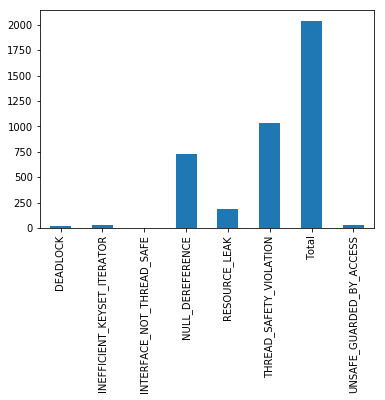

In [93]:
combined_results.sum().plot.bar()

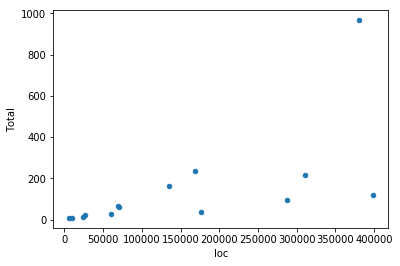

In [96]:
indexed_repos.join(combined_results).plot.scatter(x='loc',y='Total')

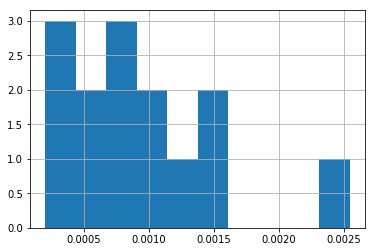

In [98]:
joined = indexed_repos.join(combined_results)
joined['div'] = joined['Total'] / joined['loc']
joined['div'].hist()

In [106]:
joined[joined['div'] > 0.002].index[0]

'dbeaver/dbeaver'

In [70]:
indexed_repos.join(results_list)

ValueError: Indexes have overlapping values: Index(['NULL_DEREFERENCE', 'THREAD_SAFETY_VIOLATION', 'RESOURCE_LEAK',
       'INEFFICIENT_KEYSET_ITERATOR', 'INTERFACE_NOT_THREAD_SAFE'],
      dtype='object')

In [ ]:
res = simplify_results(get_results_for_num(2))

In [25]:
res

[{'type': 'NULL_DEREFERENCE',
  'file': 'retrofit/src/main/java/retrofit2/OkHttpCall.java'},
 {'type': 'RESOURCE_LEAK',
  'file': 'samples/src/main/java/com/example/retrofit/ChunkingConverter.java'},
 {'type': 'NULL_DEREFERENCE',
  'file': 'retrofit/src/main/java/retrofit2/RequestBuilder.java'},
 {'type': 'NULL_DEREFERENCE',
  'file': 'retrofit-converters/jaxb/src/main/java/retrofit2/converter/jaxb/JaxbRequestConverter.java'},
 {'type': 'THREAD_SAFETY_VIOLATION',
  'file': 'retrofit/src/main/java/retrofit2/Retrofit.java'},
 {'type': 'THREAD_SAFETY_VIOLATION',
  'file': 'retrofit/src/main/java/retrofit2/Retrofit.java'},
 {'type': 'RESOURCE_LEAK',
  'file': 'samples/src/main/java/com/example/retrofit/AnnotatedConverters.java'},
 {'type': 'NULL_DEREFERENCE',
  'file': 'retrofit/src/main/java/retrofit2/RequestFactory.java'},
 {'type': 'NULL_DEREFERENCE',
  'file': 'retrofit/src/main/java/retrofit2/RequestBuilder.java'},
 {'type': 'NULL_DEREFERENCE',
  'file': 'retrofit/src/main/java/retrof

In [ ]:

json.loads()

In [26]:
results_df = pd.DataFrame(res)

In [27]:
results_df.head()

,file,type
0,retrofit/src/main/java/retrofit2/OkHttpCall.java,NULL_DEREFERENCE
1,samples/src/main/java/com/example/retrofit/Chu...,RESOURCE_LEAK
2,retrofit/src/main/java/retrofit2/RequestBuilde...,NULL_DEREFERENCE
3,retrofit-converters/jaxb/src/main/java/retrofi...,NULL_DEREFERENCE
4,retrofit/src/main/java/retrofit2/Retrofit.java,THREAD_SAFETY_VIOLATION


In [28]:
netty_results =  results_df.groupby('type').count().T.set_index(pd.Index(['square/retrofit']))

In [29]:
repos2 = repos.set_index('repo')

In [30]:
repos2.join(netty_results)

,loc,jobid,status,job_complete,job_status,NULL_DEREFERENCE,RESOURCE_LEAK,THREAD_SAFETY_VIOLATION
repo,,,,,,,,
ReactiveX/RxJava,310530,01EAYH6X015R4EDRYNP5EJD0QX,"""JobCodeAcquired""",False,running,NaN,NaN,NaN
google/guava,398320,01EAYH6XJ8R8NZJ96PWBP187JV,"""JobCodeAcquired""",False,running,NaN,NaN,NaN
square/retrofit,26496,01EAYH6Y0QD9YC0NA3YPJ163Y0,"""JobCompleteSuccess""",True,complete,9.0,10.0,2.0
apache/dubbo,168990,01EAYH6YGPV56TBFAMKFMJEFSR,"""JobCodeAcquired""",False,running,NaN,NaN,NaN
netty/netty,287499,01EAYH6YZ4KTQSGARKRGPA1Y74,"""JobCodeAcquired""",False,running,NaN,NaN,NaN
greenrobot/EventBus,5364,01EAYH6ZDW2HSBF4BC7W3T5M3Q,"""JobCompleteSuccess""",True,complete,NaN,NaN,NaN
skylot/jadx,69902,01EAYH6ZWN3H2ZY0QCQM1F93ET,"""JobCodeAcquired""",False,running,NaN,NaN,NaN
alibaba/fastjson,176268,01EAYH70A6VKJG966JY99QYB15,"""JobCompleteSuccess""",True,complete,NaN,NaN,NaN
alibaba/arthas,39472,01EAYH70PGXKDWDYK7HGHNMK2G,"""JobCompleteSuccess""",True,complete,NaN,NaN,NaN


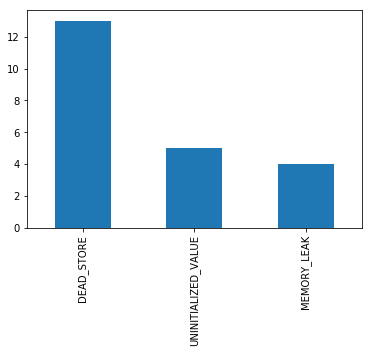

In [69]:
results_df['type'].value_counts().plot(kind='bar')